In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
import seaborn as sns
import string
from sklearn.cluster import KMeans
import pickle as pickle

In [2]:
directory = 'JEOPARDY_CSV.csv'
fulldata = pd.read_csv(directory).dropna()

In [3]:
fulldata = fulldata[fulldata[' Value'] != 'None']
fulldata = fulldata[fulldata[' Round'] == 'Jeopardy!']
fulldata = fulldata.reset_index(drop=True)

count = 0
for amount in fulldata[' Value']:
    fulldata.at[count, ' Value'] = int(amount.replace('$','').replace(',',''))
    count += 1
fulldata.head()

questiondata = fulldata[[' Value', ' Question', ' Round', ' Answer']].head(5000) #taking just the first 5000 questions because otherwise the dataframe is too big

In [7]:
questiondata = questiondata[(questiondata[' Value'] < 1001)]
questiondata = questiondata[questiondata[' Value'] != 300]
questiondata = questiondata[questiondata[' Value'] != 500]
questiondata = questiondata[questiondata[' Value'] != 100]
questiondata = questiondata[questiondata[' Value'] != 900]
questiondata = questiondata[questiondata[' Value'] != 700] #I looked for a better way to strip out all other values but couldn't find one

questiondata = questiondata.reset_index(drop=True) #for some reason the index gets messed up when I do this

In [8]:
exclude = set(string.punctuation)
count = 0
for question in questiondata[' Question']:
    question = ''.join(ch for ch in question if ch not in exclude)
    questiondata.at[count, ' Question'] = question.lower()
    count += 1 #this box just removes puncuation and capitalization so that all words are identical

In [9]:
questiondata = questiondata[~questiondata[' Question'].str.contains('href')].reset_index(drop=True) #removes video questions

In [11]:
allwords = []
questiondict = {}
allwordstring = ""

count = 0
for question in questiondata[' Question']:
    questiondict[count] = word_tokenize(question) #splits questions into words
    allwordstring += ' ' + question
    count+=1

In [13]:
allwords = word_tokenize(allwordstring)
allwords = list(dict.fromkeys(allwords)) #makes a list of all words (word bag)

In [14]:
worddict = {}
count = 0
for word in allwords:
    worddict[count] = word #makes a dict of all words for iteration
    count+=1

In [15]:
iterate = pd.DataFrame(index=questiondict.keys(), columns=worddict.values()) #empty df for iteration

In [ ]:
alldata = []

for row, words in iterate.iterrows():
    if row % 250 == 0:
        print(row)
    countdict = []
    for word in words.keys():
        countdict.append(questiondict[row].count(word))
    iterate.loc[row] = countdict #adding results of counting into a 2 dimensional array

In [12]:
df = pd.DataFrame(alldata, columns = worddict.values()) #adding 2D array into main df

In [ ]:
csv = df.to_csv('ALLDATA.csv').reset_index(drop=True) #saving df so that I can start here instead of repeating this entire process every time

In [ ]:
df = pd.read_csv('ALLDATA.csv')
df = df.drop(['Unnamed: 0'],axis=1) #for some reason it adds an extra index column??

In [ ]:
df

In [4]:
clusterdict = {'num':[], 'error':[]}

for num in range(15):
    print(num)
    if num > 0:
        kmeans = KMeans(n_clusters=num)
        kmeans.fit(df)
        clusterdict['num'].append(num)
        clusterdict['error'].append(kmeans.inertia_)

df_inertia = pd.DataFrame.from_dict(clusterdict) #this gives the elbow plot but it takes forever

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


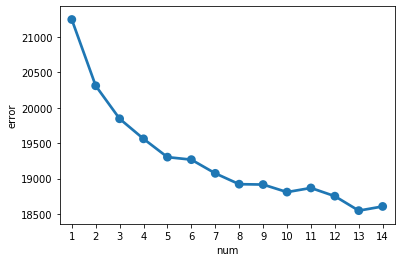

In [5]:
sns.pointplot('num', 'error', data = df_inertia, size=5,aspect=1) #graphs the elbow plot

In [6]:
kmeans = KMeans(5) #5 is the actual number of values that I have (200, 400, 600, 800, 1000)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
pkl_filename = "picklemodel.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(kmeans, file) #saving the model to use in the web app

In [21]:
np_data = df.values
labels = []

labels = kmeans.predict(np_data)
questiondata['labels'] = labels

for row in np_data:
    vals = row.reshape(1, -1)
    label = kmeans.predict(vals)
    label= label[0]
    labels.append(label)
print(len(questiondata))
print(len(labels))
questiondata['labels'] = labels #adding labels back into df

3559
1568


ValueError: Length of values does not match length of index

In [ ]:
sns.countplot(x=' Value', hue='labels',palette='rainbow', data=questiondata) #plots the final labels (inconclusive)